# Data Self Study

## Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime
sns.set()

## Initiate variables

In [5]:
# SET THESE VARIABLES BEFORE RUNNING CELLS
year = 2019 # year of dataset
bool_concat_years = False # True: concatenate years
bool_full_weeks = False # True: discard partial weeks

In [6]:
mins_day = 1440 # number of minutes in a day
# dictionary defining which activities belong to which group
groups = {
    'Humanities Hobbies' : ['art', 'learnlang', 'piano', 'read', 'writing', 'dogwalk'],
    'Miscellaneous' : ['misc', 'sick', 'bedtime', 'liesure'],
    'Math & Science Hobbies' : ['math', 'coding', 'dataentry', 'datasci'],
    'Eating' : ['eat', 'snack'],
    'Obligations' : ['errands', 'housework', 'study'],
    'Gaming' : ['games', 'vidgames'],
    'Work' : ['job', 'workmisc'],
    'Entertainment' : ['outing', 'liveevent', 'tv', 'movie'],
    'Sleep' : ['sleep'],
    'Internet' : ['internet'],
    'Social' : ['social'],
    'Travel' : ['travel'],
    'Hygiene' : ['hygiene'],
    'Romance' : ['romance'],
    'Exercise' : ['exercise']
}

## Functions

In [7]:
# process_data: adds hour_sum and min_sum columns for time elapsed; adds weekday/datetime columns
# param: dataframe (raw data with original columns)
# returns dataframe

def process_data(df):
    # find time elapsed
    df['hour_sum'] = df['hour'].diff()
    df['min_sum'] = df['min'].diff()
    # correct for times elapsed over midnight
    df['hour_sum'] = np.where(df['hour_sum'] < 0, df['hour_sum'] + 24, df['hour_sum'])
    df['hour_sum'] = np.where(df['min_sum'] < 0 , df['hour_sum'] - 1, df['hour_sum'])
    df['min_sum'] = np.where(df['min_sum'] < 0, df['min_sum'] + 60, df['min_sum'])
    # shift data so elapsed times are paired correctly
    df[['hour_sum', 'min_sum']] = df[['hour_sum', 'min_sum']].shift(-1)
    df = df.drop(data.index[-1])
    # create datetime column and weekday column
    df['datetime'] = pd.to_datetime(df['year']*10000 + df['month']*100 + df['day'], format='%Y%m%d')
    df['weekday'] = df['datetime'].dt.weekday
    return df

In [8]:
# timestamps: adds a row for every hour not included in original data (new dataframe)
# param: dataframe (raw data with original columns)
# returns dataframe

# TODO: optimize?

def timestamps(df):
    rows_extra = list()
    for index, row in df[:len(df) - 1].iterrows():
        # add missing hours
        now_h = row['hour']
        next_h = df.loc[index + 1]['hour']
        # flow control accounts for times between months or days
        if now_h > next_h:
            next_h += 24
        while now_h < next_h:
            now_h += 1
            if (now_h == next_h) and (df.loc[index + 1]['min'] == 0):
                continue
            if now_h >= 24:
                if row['month'] != df.loc[index + 1]['month']:
                    extra_row = [row['year'], df.loc[index + 1]['month'], df.loc[index + 1]['day'],
                                 now_h % 24, 0, row['activity'], row['sub_activity']]
                else:
                    extra_row = [row['year'], row['month'], df.loc[index + 1]['day'], now_h % 24, 0,
                                 row['activity'], row['sub_activity']]
            else:
                extra_row = [row['year'], row['month'], row['day'], now_h, 0, row['activity'], row['sub_activity']]
            rows_extra.append(extra_row)
    # create new dataframe from extra rows
    data_extra = pd.DataFrame(rows_extra, columns=df.columns)
    # append extra data to data_ts dataframe (ts stands for timestamps)
    data_ts = df.append(data_extra)
    data_ts = data_ts.sort_values(by=['month', 'day', 'hour', 'min'])
    data_ts = data_ts.reset_index(drop=True)
    return data_ts

In [9]:
# subdiv_data: subdivide data given string 'month', 'week', or 'day'
# params: dataframe (must include columns month, weekday, day), string
# returns dataframe

def subdiv_data(df, key):
    df_copy = df.copy()
    if key == 'month':
        key_index = df_copy.index[df_copy['month'].diff() == 1].tolist()
    elif key == 'week':
        key_index = df_copy.index[df_copy['weekday'].diff() == -6].tolist()
    elif key == 'day':
        key_index = df_copy.index[(df_copy['day'].diff() == 1) | (df_copy['day'].diff() < 0)].tolist()
    key_index = [0] + key_index + [len(df_copy)]
    df_key = list()
    i = 0
    while i < len(key_index) - 1:
        df_key.append(df_copy[key_index[i]:key_index[i+1]])
        i += 1
    return df_key

# create list of grouped and summed df's from weekly df list
#weeks_grouped_sum = list()
#for item in data_full_weeks:
#    weeks_grouped_sum.append(group_activities(sum_activities(item), groups))

In [10]:
# sum_activities: sum up hours per activity
# param: dataframe (must include columns activity, sub_activity, hour_sum, min_sum)
# returns dataframe

def sum_activities(df):
    
    # find hours per activity
    activity_sum = df.groupby(['activity'])['hour_sum', 'min_sum'].sum()
    sub_activity_sum = df.groupby(['sub_activity'])['hour_sum', 'min_sum'].sum()
    all_activity_sum = activity_sum.add(sub_activity_sum, fill_value=0)
    
    # convert minutes into hours
    all_activity_sum['hour_sum'] = all_activity_sum['hour_sum'] + all_activity_sum['min_sum'] // 60
    all_activity_sum['min_sum'] = all_activity_sum['min_sum'] % 60
    
    # all_activity_sum_h for hour decimals
    all_activity_sum_h = all_activity_sum
    all_activity_sum_h['hour_sum'] = all_activity_sum_h['hour_sum'] + all_activity_sum_h['min_sum'] / 60
    all_activity_sum_h = all_activity_sum_h.drop(['min_sum'], axis=1)
    all_activity_sum_h = all_activity_sum_h.sort_values('hour_sum', ascending=False)
    
    return all_activity_sum_h

In [11]:
# group_activities: merge activities and their data into groups (meant for use with summed data)
# params: dataframe (must include column hour_sum), dictionary
# returns dataframe

def group_activities(df):
    
    # add activity with value 0 if not in dataframe
    for key in groups:
        for item in groups[key]:
            if not item in df.index:
                df.loc[item] = 0
                
    # create new df for grouped activites
    df_grouped = df.copy()
    
    # group up activities
    for key in groups:
        df_grouped.loc[groups[key][0]] = df_grouped.loc[groups[key]].sum()
        df_grouped.drop(groups[key][1:], inplace=True)
        
    # rename activities
    for key in groups:
        df_grouped.rename(index={groups[key][0] : key}, inplace=True)
        
    # sort descending
    df_grouped = df_grouped.sort_values('hour_sum', ascending=False)
    
    return df_grouped

In [12]:
# plot_activity_hrs: plots total hours per activity
# params: dataframe (2 columns)

def plot_activity_hrs(df):
    vis = df.plot(kind='bar', title ="Total Hours per Activity", figsize=(15, 10), fontsize=12)
    vis.set_xlabel("Activity", fontsize=12)
    vis.set_ylabel("Hours", fontsize=12)
    plt.show()

In [13]:
# plot_timely_avg: plots average hours of given activity per time interval
# params: string (name of activity), string (name of time interval: month or week),
# time_list (list containing dataframes split up by time interval)

# TODO change x-axis to actual dates
# TODO add full weeks param
# TODO optimize! idea: use index to grab from both grouped list and regular list?

def plot_timely_avg(activity, time):
    if time == 'month':
        time_list = data_months
    elif time == 'week':
        time_list = data_weeks
    elif time == 'day':
        time_list = data_days
    x = list()
    y = list()
    for index, item in enumerate(time_list):
        span = item['day'].nunique()
        x.append(item.iloc[0]['datetime'])
        item_grouped = group_activities(sum_activities(item)) #this line is processing heavy!!!
        y.append(item_grouped.loc[activity]['hour_sum'] / span) 
    # plot
    plt.figure(figsize=(15,10))
    plt.xticks(rotation=90)
    plt.bar(x,y, align='center', alpha=0.5)
    plt.xlabel(time.capitalize())
    plt.ylabel('Average Hours')
    plt.title(activity.capitalize())
    plt.show()

In [14]:
# activity_per_time: plot number of activity per time interval
# params: string (name of activity), time_list (list containing dataframes split up by time interval),
# time (name of time interval)

# TODO change x-axis to actual dates
# TODO add full weeks param

def plot_activity_per_time(activity, time):
    if time == 'month':
        time_list = data_months
    elif time == 'week':
        time_list = data_weeks
    elif time == 'day':
        time_list = data_days
    x = list()
    y = list()
    for index, item in enumerate(time_list):
        x.append(index + 1)
        y.append(len(item[item['activity'] == activity]))
    plt.figure(figsize=(20,10))
    plt.bar(x, y, align='center', alpha=0.5)
    plt.xlabel(time.capitalize())
    plt.ylabel(activity.capitalize() + ' count')
    plt.title(activity.capitalize() + ' count per ' + time)
    plt.show()

In [15]:
# find_avg_time: find average time of dataframe
# params: dataframe (must include columns hour, min)

def find_avg_time(df):
    df_sleep_data = df.copy()
    df_sleep_data['radians'] = ((df_sleep_data['hour'] * 60 + df_sleep_data['min']) * np.pi * 2) / mins_day
    cos_sum = np.cos(df_sleep_data['radians']).sum()
    sin_sum = np.sin(df_sleep_data['radians']).sum()
    avg_time_rad = np.arctan2(sin_sum, cos_sum)
    avg_time_mins = (avg_time_rad * mins_day) / (np.pi * 2)
    avg_time_h = int(avg_time_mins // 60)
    avg_time_m = int(np.rint(avg_time_mins % 60))
    print("Average time: " + str(avg_time_h) + ":" + str(avg_time_m))

In [16]:
# common_act: find most common activity per hour interval
# param: dataframe (must be timestamps df)
# returns dataframe

def common_act(df):
    max_act_by_h = list()
    i = 0
    while i < 24:
        act_freq = df[(df['hour'] >= i) & (df['hour'] < i + 1)].groupby(['activity']).count()
        max_act_by_h.append(act_freq.idxmax()['year'])
        i += 1
    common_df = pd.DataFrame(max_act_by_h, columns=['activity'])
    return common_df

## Load, process, and verify data

In [17]:
# load raw data
data = pd.read_csv('My_Data_' + str(year) + '.csv')

In [18]:
data_ts = timestamps(data)

In [19]:
# add hour_sum, min_sum, datetime, weekday columns
data = process_data(data)

In [20]:
# subdivide data
data_months = subdiv_data(data, 'month')
data_weeks = subdiv_data(data, 'week')
data_days = subdiv_data(data, 'day')

# exclude partial weeks
data_full_weeks = data_weeks[1:len(data_weeks)-1]

In [21]:
# verify accuracy of entered data
# TODO automate this later

# note: data incorrectly entered as 12 hr clock time will come in "large pairs"
# ie two adjacent activities that both have times > 12 hrs

# visual check
data[(data['hour_sum'] > 7) & (data['activity'] != 'sleep')]

,year,month,day,hour,min,activity,sub_activity,hour_sum,min_sum,datetime,weekday
1018,2019,3,9,15,45,social,eat,8.0,10.0,2019-03-09,5


## Analyze data

### Total hours by activity

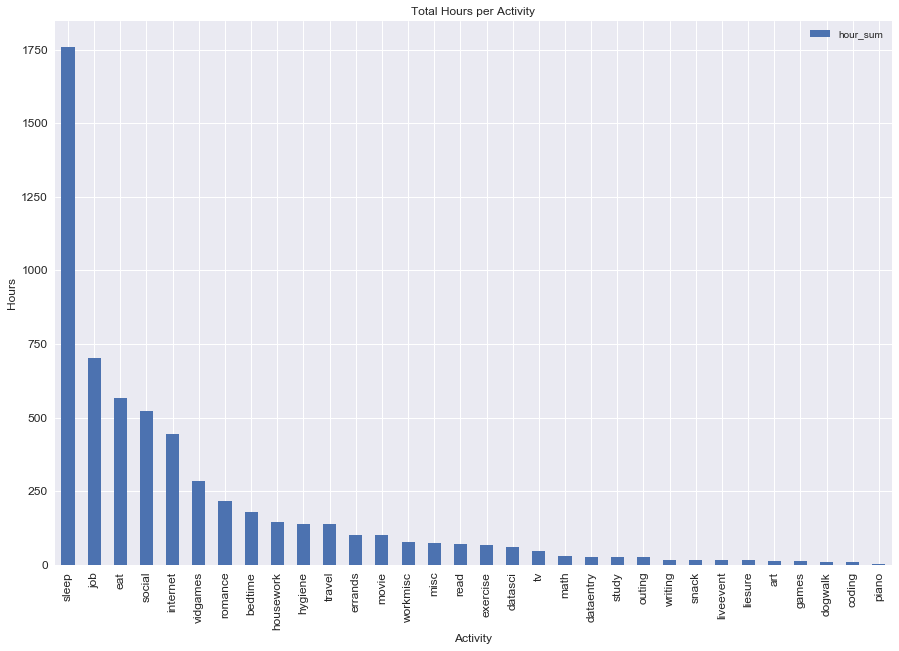

In [22]:
activity_sum = sum_activities(data)
plot_activity_hrs(activity_sum)

### Total hours by activity (grouped)

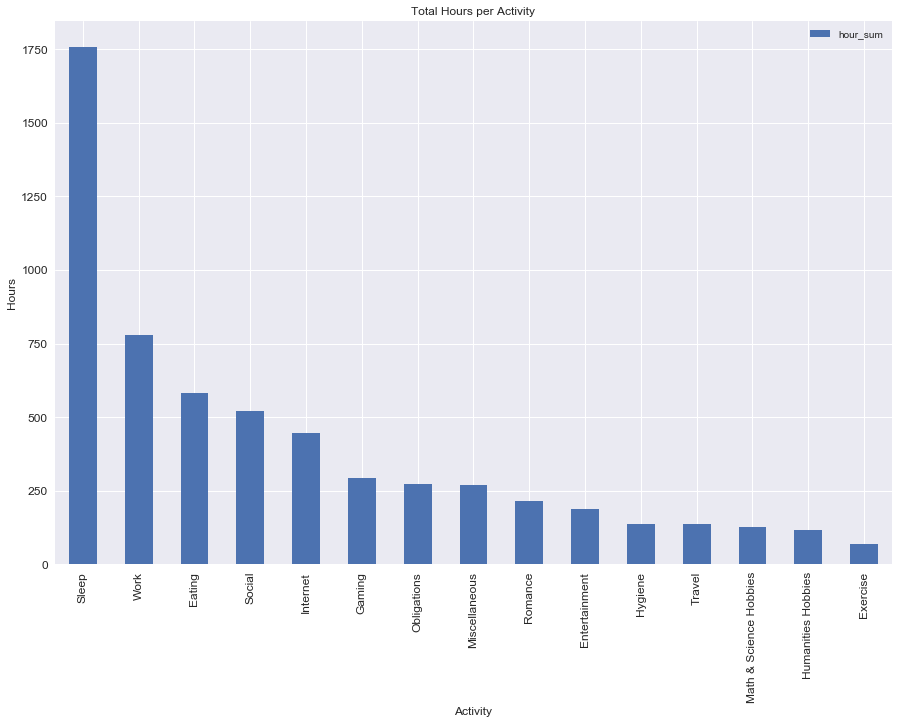

In [23]:
activity_grouped = group_activities(activity_sum)
plot_activity_hrs(activity_grouped)

### Average activity hours per time interval

In [24]:
# Average hours per day for all activities
activity_grouped / len(data_days)

,hour_sum
Sleep,7.850595
Work,3.475670
Eating,2.596503
Social,2.333036
Internet,1.985789
Gaming,1.315402
Obligations,1.225595
Miscellaneous,1.198363
Romance,0.961384
Entertainment,0.846205


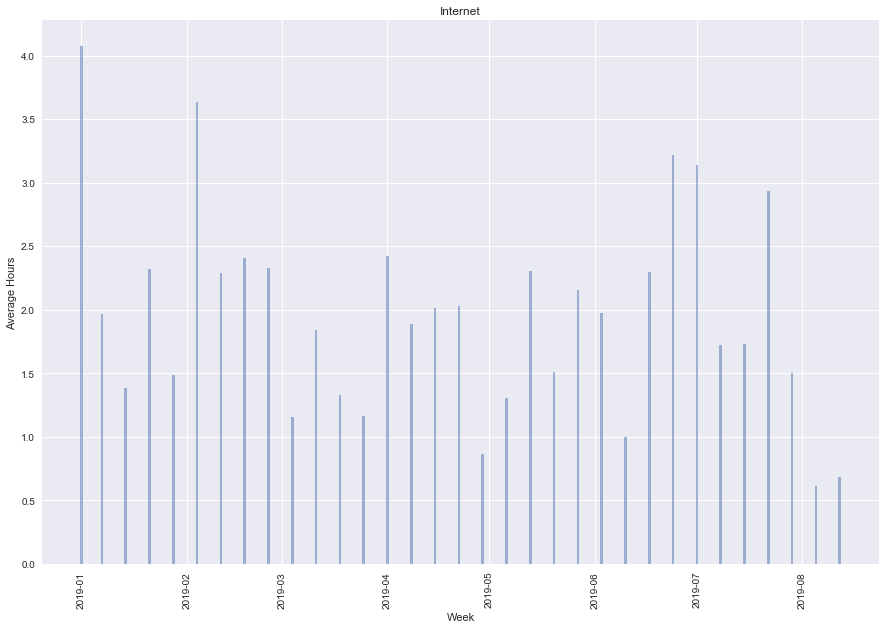

In [25]:
# average internet hours per week
plot_timely_avg('Internet', 'week')

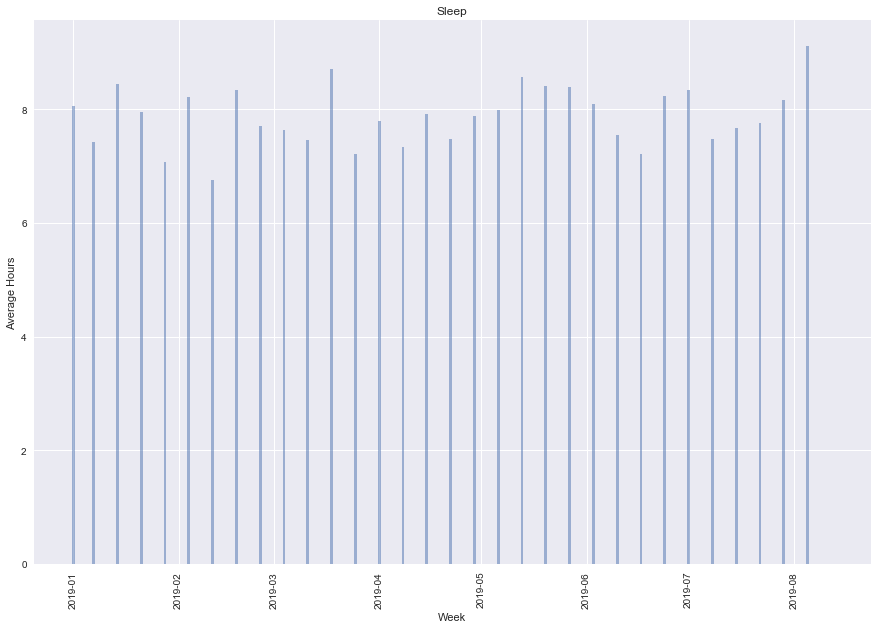

In [26]:
# average sleep hours per week
plot_timely_avg('Sleep', 'week')

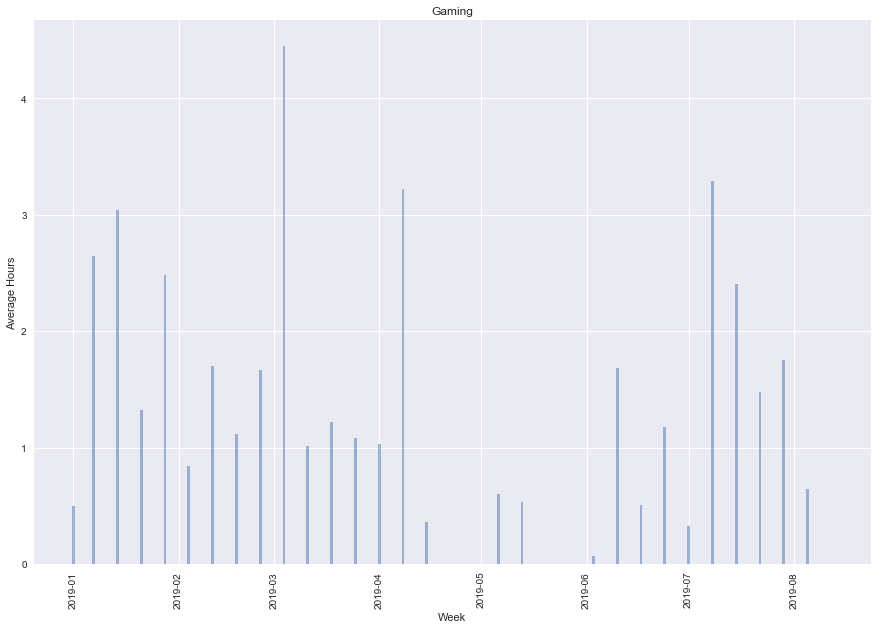

In [27]:
# average gaming hrs per week
plot_timely_avg('Gaming', 'week')

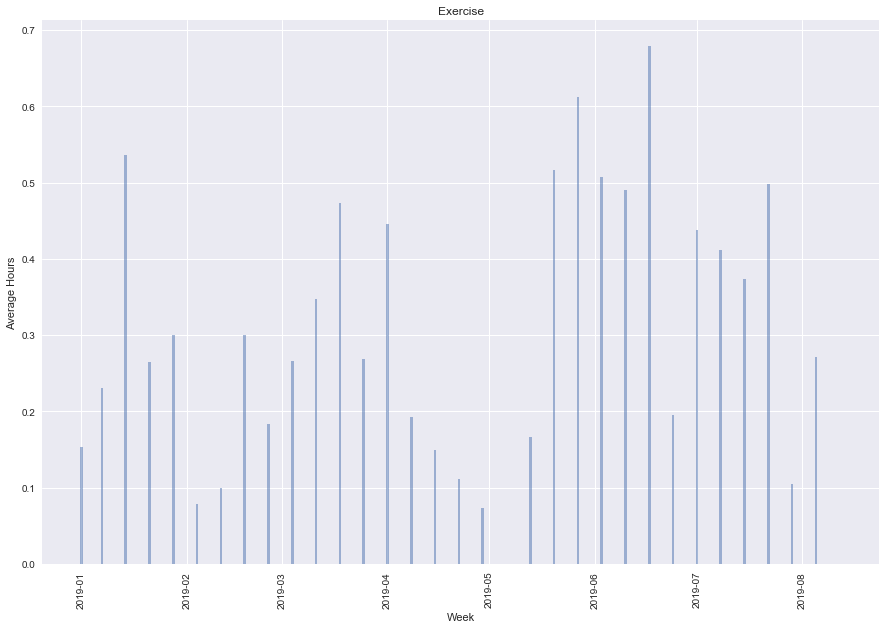

In [28]:
# average exercise hrs per week
plot_timely_avg('Exercise', 'week')

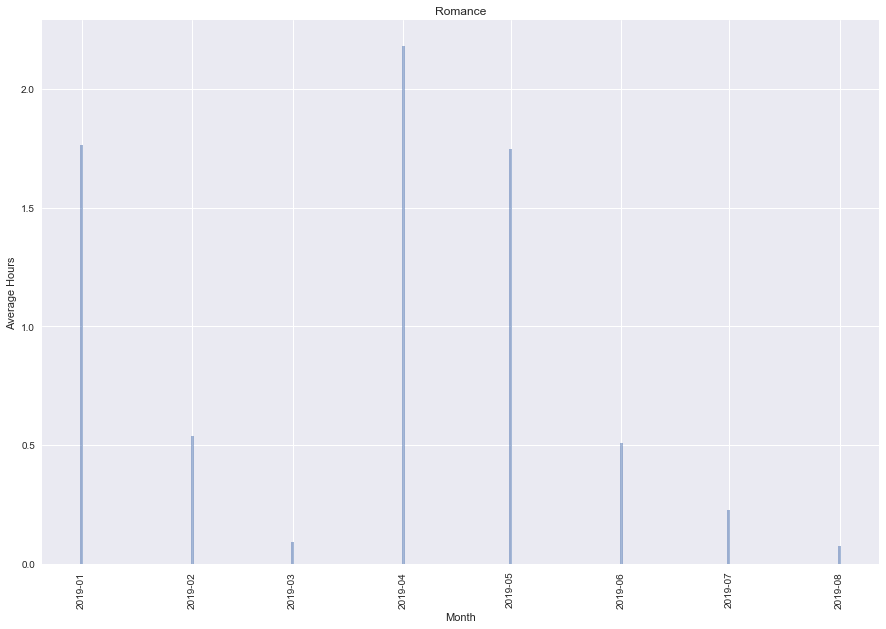

In [29]:
# average romance hrs per day by month
plot_timely_avg('Romance', 'month')

### Number of activity per time interval

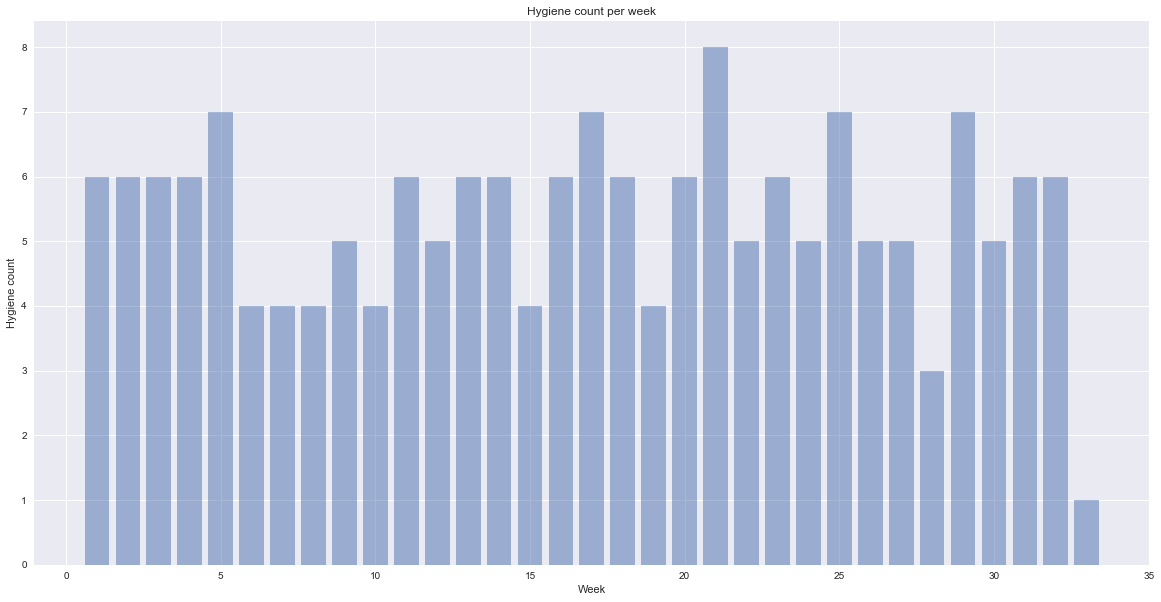

In [31]:
# plot showers per week
plot_activity_per_time('hygiene', 'week')

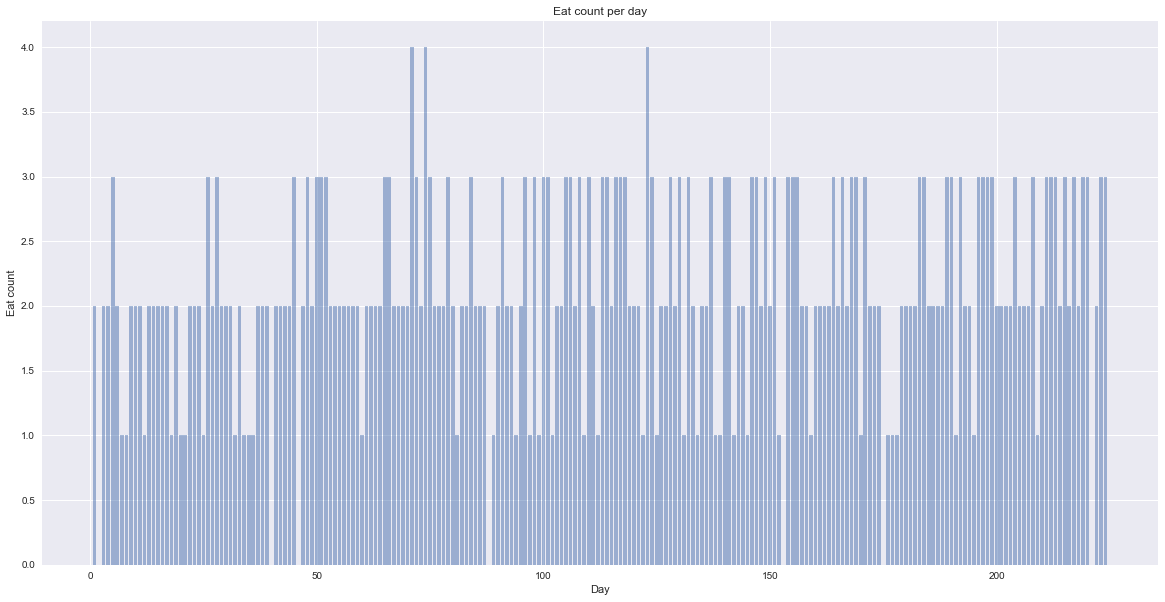

In [32]:
# plot meals per day
plot_activity_per_time('eat', 'day')

In [33]:
# Average meals per day
(len(data[data['activity'] == 'eat']) + len(data[data['activity'] == 'snack'])/2) / len(data_days)

2.142857142857143

### Average bedtime and wake time

In [34]:
# subdivide into df's with info about sleep and post-sleep (wake) times
sleep_data = data[['hour', 'min','activity']][data['activity'] == 'sleep']
sleep_index = list(np.where(data['activity'] == 'sleep'))
wake_index = [item + 1 for item in sleep_index]
wake_data = data.iloc[wake_index[0]]

In [35]:
# Average bed time
find_avg_time(sleep_data)

Average time: 1:20


In [36]:
# Average wake time
find_avg_time(wake_data)

Average time: 8:33


### Most common activity by time of day

In [37]:
# list most common activity for each time interval
common_activities = common_act(data_ts)
common_activities

,activity
0,sleep
1,sleep
2,sleep
3,sleep
4,sleep
5,sleep
6,sleep
7,sleep
8,sleep
9,internet
